In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os



/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


## Import data:
Using jetImages_signal.npz and jetImages_bkg.npz to train the neural network and using jetImages_signal_test.npz and jetImages_bkg_test.npz for testing.

In [2]:
# #list_ds = tf.data.Dataset.list_files('data/jetImages*.npz')
# list_ds = tf.data.Dataset.list_files('/mnt/data/ml/ShowJetsData.npz')

# l_jetImages = []
# l_labels = []
# n = 5 #take number of files
# n_images = 0 #number of images in one file
# for f1 in list_ds.take(n):
#     print(f1.numpy())
#     with np.load(f1.numpy()) as data:

#         jetImages  = np.array(data['jetImages'])
#         n_images += len(jetImages)
#         l_jetImages.append(jetImages)
#         labels  = data['labels']
#         l_labels.append(labels)
#         print(labels.shape)
#         print(jetImages.shape)


# l_jetImages = np.array(l_jetImages).reshape(n_images,16,16,1)
# l_labels = np.array(l_labels).reshape(n_images,4)


In [21]:
data = np.load('/mnt/data/ml/ShowJetsDataTest.npz')
# !ls /mnt/data/ml/
images = data['jetImages']
labels = data['labels']



#varlist = ['tau21', 'chMult']
#nVar = len(varlist)
#temp = np.zeros((nVar, labels.shape[0]))
#for n in range(nVar):
#   temp[n] = data[varlist[n]]
#var = np.vstack((temp))    
    
# old individually called variables
tau21 = data['tau21']
chMult = data['chMult']
neutMult = data['neutMult']
phoMult = data['phoMult']
eleMult = data['eleMult']
muMult = data['muMult']

## data = stack all of them, then split them up after

print(chMult.shape)

grid = np.size(images, 1)
#ensure same number of signal vs. background and even split of z events
qcd_im = images[np.where(labels[:,0] == 1)]
qcd_tau = tau21[np.where(labels[:,0] == 1)]
qcd_mult = chMult[np.where(labels[:,0] == 1)]
qcd_neutMult = neutMult[np.where(labels[:,0] == 1)]
qcd_eleMult = eleMult[np.where(labels[:,0] == 1)]
qcd_phoMult = phoMult[np.where(labels[:,0] == 1)]
qcd_muMult = eleMult[np.where(labels[:,0] == 1)]

if len(qcd_im) % 3 != 0:
    qcd_im = qcd_im[:len(qcd_im)-(len(qcd_im) % 3)]
    qcd_tau = qcd_tau[:len(qcd_im)-(len(qcd_im) % 3)]
    qcd_mult = qcd_mult[:len(qcd_im)-(len(qcd_im) % 3)]

z1_im = images[np.where(labels[:,1] == 1)]
z1_im = z1_im[:int(len(qcd_im)/3)]
z1_tau = tau21[np.where(labels[:,1] == 1)]
z1_tau = z1_tau[:int(len(qcd_im)/3)]
z1_mult = chMult[np.where(labels[:,1] == 1)]
z1_mult = z1_mult[:int(len(qcd_im)/3)]
z1_neutMult = neutMult[np.where(labels[:,1] == 1)]
z1_neutMult = z1_neutMult[:int(len(qcd_im)/3)]
z1_phoMult = phoMult[np.where(labels[:,1] == 1)]
z1_phoMult = z1_phoMult[:int(len(qcd_im)/3)]
z1_eleMult = eleMult[np.where(labels[:,1] == 1)]
z1_eleMult = z1_eleMult[:int(len(qcd_im)/3)]
z1_muMult = muMult[np.where(labels[:,1] == 1)]
z1_muMult = z1_muMult[:int(len(qcd_im)/3)]

z2_im = images[np.where(labels[:,2] == 1)]
z2_im = z2_im[:int(len(qcd_im)/3)]
z2_tau = tau21[np.where(labels[:,2] == 1)]
z2_tau = z2_tau[:int(len(qcd_im)/3)]
z2_mult = chMult[np.where(labels[:,2] == 1)]
z2_mult = z2_mult[:int(len(qcd_im)/3)]
z2_neutMult = neutMult[np.where(labels[:,2] == 1)]
z2_neutMult = z2_neutMult[:int(len(qcd_im)/3)]
z2_phoMult = phoMult[np.where(labels[:,2] == 1)]
z2_phoMult = z2_phoMult[:int(len(qcd_im)/3)]
z2_eleMult = eleMult[np.where(labels[:,2] == 1)]
z2_eleMult = z2_eleMult[:int(len(qcd_im)/3)]
z2_muMult = muMult[np.where(labels[:,2] == 1)]
z2_muMult = z2_muMult[:int(len(qcd_im)/3)]

z3_im = images[np.where(labels[:,3] == 1)]
z3_im = z3_im[:int(len(qcd_im)/3)]
z3_tau = tau21[np.where(labels[:,3] == 1)]
z3_tau = z3_tau[:int(len(qcd_im)/3)]
z3_mult = chMult[np.where(labels[:,3] == 1)]
z3_mult = z3_mult[:int(len(qcd_im)/3)]
z3_neutMult = neutMult[np.where(labels[:,3] == 1)]
z3_neutMult = z3_neutMult[:int(len(qcd_im)/3)]
z3_phoMult = phoMult[np.where(labels[:,3] == 1)]
z3_phoMult = z3_phoMult[:int(len(qcd_im)/3)]
z3_eleMult = eleMult[np.where(labels[:,3] == 1)]
z3_eleMult = z3_eleMult[:int(len(qcd_im)/3)]
z3_muMult = muMult[np.where(labels[:,3] == 1)]
z3_muMult = z3_muMult[:int(len(qcd_im)/3)]

qcd_lab = np.zeros([len(qcd_im), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_im), 2])
z_lab[:,1] = 1
images = np.vstack((qcd_im, z1_im, z2_im, z3_im))
taus = np.hstack((qcd_tau, z1_tau, z2_tau, z3_tau))
mults = np.hstack((qcd_mult, z1_mult, z2_mult, z3_mult))
neutMults = np.hstack((qcd_neutMult, z1_neutMult, z2_neutMult, z3_neutMult))
phoMults = np.hstack((qcd_phoMult, z1_phoMult, z2_phoMult, z3_phoMult))
eleMults = np.hstack((qcd_eleMult, z1_eleMult, z2_eleMult, z3_eleMult))
muMults = np.hstack((qcd_muMult, z1_muMult, z2_muMult, z3_muMult))


labels = np.vstack((qcd_lab, z_lab))
n_data = len(images)
images = images.reshape(n_data, grid, grid, 1)

#split data into testing/training/validation

testimages = images[::4]
testlabels = labels[::4]
testtaus = taus[::4]
testmults = mults[::4]

testNeutMults = neutMults[::4]
testPhoMults = phoMults[::4]
testEleMults = eleMults[::4]
testMuMults = muMults[::4]

testNeutMults = testNeutMults[:-1]
testPhoMults = testPhoMults[:-1]
testEleMults = testEleMults[:-1]
testMuMults = testMuMults[:-1]

mask_im = np.ones(images.shape,dtype=bool)
mask_im[::4] = 0
mask_im[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0

mask_tau = np.ones(taus.shape,dtype=bool)
mask_tau[::4] = 0
mask_tau[1::8] = 0
mask_mult = np.ones(mults.shape,dtype=bool)
mask_mult[::4] = 0
mask_mult[1::8] = 0
mask_neutMult = np.ones(neutMults.shape,dtype=bool)
mask_neutMult[::4] = 0
mask_neutMult[1::8] = 0
mask_phoMult = np.ones(neutMults.shape,dtype=bool)
mask_phoMult[::4] = 0
mask_phoMult[1::8] = 0
mask_eleMult = np.ones(neutMults.shape,dtype=bool)
mask_eleMult[::4] = 0
mask_eleMult[1::8] = 0
mask_muMult = np.ones(neutMults.shape,dtype=bool)
mask_muMult[::4] = 0
mask_muMult[1::8] = 0

valimages = images[1::8]
vallabels = labels[1::8]
valtaus = taus[1::8]
valmults = mults[1::8]
valNeutMults = neutMults[1::8]
valPhoMults = phoMults[1::8]
valEleMults = eleMults[1::8]
valMuMults = muMults[1::8]

trainimages = images[mask_im].reshape((n_data-len(testimages)-len(valimages)), grid, grid, 1)
trainlabels = labels[mask_lab].reshape((n_data-len(testimages)-len(valimages)), 2)
traintaus = taus[mask_tau].reshape((n_data-len(testimages)-len(valimages)), 1)
trainmults = mults[mask_mult].reshape((n_data-len(testimages)-len(valimages)), 1)
trainNeutMults = neutMults[mask_neutMult].reshape((n_data-len(testimages)-len(valimages)), 1)
trainPhoMults = phoMults[mask_phoMult].reshape((n_data-len(testimages)-len(valimages)), 1)
trainEleMults = eleMults[mask_eleMult].reshape((n_data-len(testimages)-len(valimages)), 1)
trainMuMults = muMults[mask_muMult].reshape((n_data-len(testimages)-len(valimages)), 1)

print(trainimages.shape)
print(trainlabels.shape)
print(traintaus.shape)
print(trainmults.shape)
print(trainNeutMults.shape)
print(trainPhoMults.shape)
print(trainEleMults.shape)
print(trainMuMults.shape)
print()
print(valimages.shape)
print(vallabels.shape)
print(valtaus.shape)
print(valmults.shape)
print(valNeutMults.shape)
print(valPhoMults.shape)
print(valEleMults.shape)
print(valMuMults.shape)
print()
print(testimages.shape)
print(testlabels.shape)
print(testtaus.shape)
print(testmults.shape)
print(testNeutMults.shape)
print(testPhoMults.shape)
print(testEleMults.shape)
print(testMuMults.shape)


(336227,)
(99240,)
(99241,)
(62025, 16, 16, 1)
(62025, 2)
(62025, 1)
(62025, 1)
(62025, 1)
(62025, 1)
(62025, 1)
(62025, 1)

(12405, 16, 16, 1)
(12405, 2)
(12405,)
(12405,)
(12405,)
(12405,)
(12405,)
(12405,)

(24810, 16, 16, 1)
(24810, 2)
(24810,)
(24810,)
(24810,)
(24810,)
(24810,)
(24810,)


In [5]:
# import list of files

# filelist = tf.data.Dataset.list_files(str('data/jetImages*.npz'))
# initialize new array and concatenate / append array to initialized array [DOES NOT WORK] trying zip


# for f1 in filelist_sig.take(1):
#     with np.load(f1.numpy()) as data:
#         jetImages = data['jetImages']
#         labels = data['labels']
        
# dataset = tf.data.Dataset.from_tensor_slices((l_jetImages, l_labels))
# batched_dataset = dataset.batch(4)


#for batch in batched_dataset.take(1):
#    print([arr.numpy() for arr in batch])


In [6]:
# grid = 16

# trainimages = l_jetImages[10:]
# trainlabels = l_labels[10:]

# testimages = l_jetImages[:10]
# testlables = l_labels[:10]

# print(trainimages.shape)
# print(trainlabels.shape)

In [7]:
# grid = 16
# # training data : 10,000 signal samples and 10,000 bkg samples
# #traindata_sig = np.load('data/jetImages_signal.npz')
# #traindata_bkg = np.load('data/jetImages_bkg.npz')
# trainimages = np.concatenate((traindata_sig['jetImages'], traindata_bkg['jetImages']),axis=0)
# trainlabels = np.concatenate((traindata_sig['labels'],traindata_bkg['labels']),axis=0)
# # testing data : 10,000 signal samples and 10,000 bkg samples
# testdata_sig = np.load('data/jetImages_signal_test.npz')
# testdata_bkg = np.load('data/jetImages_bkg_test.npz')
# testimages = np.concatenate((testdata_sig['jetImages'], testdata_bkg['jetImages']),axis=0)
# testlabels = np.concatenate((testdata_sig['labels'], testdata_bkg['labels']),axis=0)

# n_test = len(testlabels)
# n_train = len(trainlabels)
# trainimages = trainimages.reshape(n_train, grid, grid, 1)
# testimages = testimages.reshape(n_test, grid, grid, 1)
# print(trainimages.shape)
# print(trainlabels.shape)

In [8]:
# dataset = tf.data.Dataset.from_tensor_slices((l_jetImages, l_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((testimages, testlabels))

# batched_test_dataset = test_dataset.batch(4)

#for batch in batched_dataset.take(4):
#  print([arr.numpy() for arr in batch])


Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

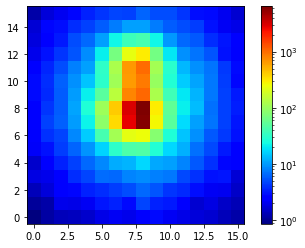

In [9]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if trainlabels[i,0] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

Build DNN:

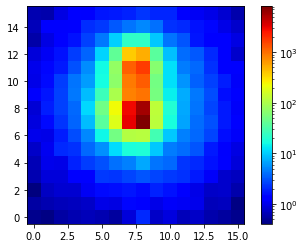

In [10]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [11]:
# def build_model():
#     model = keras.Sequential([
#         Conv2D(32, (11, 11), activation='relu',
#                input_shape=(grid, grid, 1)),
#         Conv2D(32, (3, 3), activation='relu'),
#         MaxPool2D((2, 2)),
# #         Dropout(0.2),
#         Conv2D(32, (3, 3), activation='relu'),
#         Conv2D(32, (3, 3), activation='relu'),
#         MaxPool2D((2, 2)),
# #         Dropout(0.2),
#         Flatten(),
#         #custom input layer
#         Dense(64, activation=tf.nn.relu),
#         Dense(64, activation=tf.nn.relu),
# #         Dropout(0.2),
#         Dense(1, activation=tf.nn.sigmoid)])

#     model.compile(loss='binary_crossentropy',
#                 optimizer='adam',
#                 metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
#     return model

In [14]:
import tensorflow as tf

def build_model():
    input1 = layers.Input(shape = (grid, grid, 1))
    x = layers.Conv2D(64, (12, 12), activation='relu', padding = 'same')(input1)
    x = layers.Conv2D(64, (6, 6), activation='relu', padding = 'same')(x)
    x = layers.Conv2D(64, (4, 4), activation='relu', padding = 'same')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x1 = layers.Flatten()(x)
    input2 = layers.Input(shape=(1,))
    input3 = layers.Input(shape=(1,))
    input4 = layers.Input(shape=(1,))
    input5 = layers.Input(shape=(1,))
    input6 = layers.Input(shape=(1,))
    input7 = layers.Input(shape=(1,))
    x = layers.concatenate(inputs = [x1, input2, input3, input4, input5, input6, input7], axis=-1)
    x = layers.Dense(256, activation=tf.nn.relu)(x)
    output = layers.Dense(2, activation=tf.nn.sigmoid)(x)
    model = models.Model(inputs=[input1, input2, input3, input4, input5, input6, input7], outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

Initialize model:

In [15]:
circleCNN = build_model()

Test model's prediction $before$ training:

In [16]:
example_batch = trainimages[::300]
example_labels = trainlabels[::300]
example_taus = traintaus[::300]
example_mults = trainmults[::300]
example_neutMults = trainNeutMults[::300]
example_phoMults = trainPhoMults[::300]
example_eleMults = trainEleMults[::300]
example_muMults = trainMuMults[::300]

print(example_batch.shape)
print(example_mults.shape)
print(example_neutMults.shape)
print(example_muMults.shape)
print(example_labels.shape)

example_variables = [example_batch, 
                     example_taus,
                     example_mults,
                     example_neutMults,
                     example_phoMults,
                     example_eleMults,
                     example_muMults]
                             
train_variables = [trainimages, traintaus,
                   trainmults,
                   trainNeutMults,
                   trainPhoMults,
                   trainEleMults,
                   trainMuMults
                  ]

test_variables = [testimages, 
                   testtaus,
                   testmults,
                   testNeutMults,
                   testPhoMults,
                   testEleMults,
                   testMuMults
                  ]

example_result = circleCNN.predict(x = example_variables)
results = circleCNN.evaluate(x = example_variables, y = example_labels)
print(example_result)
# print(results)

(207, 16, 16, 1)
(207, 1)
(207, 1)
(207, 1)
(207, 2)
207/207 [==============================] - 0s 2ms/step
[[0.45249477 0.324254  ]
 [0.46124515 0.34603512]
 [0.48416215 0.43399072]
 [0.47933024 0.42740828]
 [0.40113875 0.26688027]
 [0.44586796 0.3117829 ]
 [0.4458087  0.35161287]
 [0.48435208 0.46416628]
 [0.39527425 0.30078298]
 [0.4880486  0.43716267]
 [0.45658037 0.3432809 ]
 [0.48478913 0.40607122]
 [0.4662086  0.35995165]
 [0.4642917  0.34864467]
 [0.43752867 0.44890076]
 [0.4796961  0.41127917]
 [0.4632662  0.40153167]
 [0.44502833 0.35594338]
 [0.46079394 0.36843175]
 [0.4709574  0.4207907 ]
 [0.43686563 0.28105375]
 [0.46191797 0.37226653]
 [0.47074267 0.3808928 ]
 [0.4595826  0.33973944]
 [0.47346792 0.39536744]
 [0.44358906 0.26167625]
 [0.4820574  0.40586084]
 [0.4385873  0.35826102]
 [0.46245095 0.3577351 ]
 [0.47835317 0.45181945]
 [0.46714985 0.3663639 ]
 [0.47267523 0.40714657]
 [0.46384427 0.3732694 ]
 [0.44481742 0.3775252 ]
 [0.45035478 0.26526293]
 [0.4800202  0.41

In [32]:
# example_batch = trainimages[:10]
# example_labels = trainlabels[:10]
# example_result = circleCNN.predict(example_batch)
# results = circleCNN.evaluate(example_batch, example_labels)
# print(example_result)
# print(results)

Now train! (warning: if building CNN, computer tends to get loud)

In [ ]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
    
checkpoint_path = "model/CNN_cat_multi_input.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = circleCNN.fit(
  train_variables, trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.41798, saving model to model/CNN_cat_multi_input.h5

Epoch 00002: val_loss did not improve from 0.41798

Epoch 00003: val_loss improved from 0.41798 to 0.35287, saving model to model/CNN_cat_multi_input.h5

Epoch 00004: val_loss improved from 0.35287 to 0.26292, saving model to model/CNN_cat_multi_input.h5

Epoch 00005: val_loss did not improve from 0.26292

Epoch 00006: val_loss did not improve from 0.26292

Epoch 00007: val_loss did not improve from 0.26292

Epoch 00009: val_loss did not improve from 0.26292

Epoch 00010: val_loss did not improve from 0.26292


In [16]:
#dataset_shuffled = dataset.shuffle(buffer_size=1024).batch(16)

In [ ]:
# # WITH BATCHING AND SHUFFLING



# EPOCHS = 1
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history = circleCNN.fit(
#   dataset_shuffled,
#   epochs=EPOCHS)

Now make a plot that shows the pregression of accuracy through each training epoch.

In [ ]:
# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch
    
#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error')
#     plt.plot(hist['epoch'], hist['mean_squared_error'],
#              label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#              label = 'Val Error')
#     plt.ylim([0,100])
#     plt.legend()
#     plt.show()

# plot_history(history)

Load best weights.

In [18]:
!ls model
best_model = keras.models.load_model('model/CNN_cat_multi_input.h5')
best_model.summary()
results = best_model.evaluate(test_variables, testlabels)
print(results)

CNN_cat_multi_input_3inputs.h5	CNN_cat_multi_input.h5	     CNN_sparce_cat.h5
CNN_cat_multi_input_5E.h5	CNN_cat_multi_input_taus.h5  RNN.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   9280        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 64)   147520      conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 64)   65600       conv

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

(24810,)
(24810, 16, 16, 1)
(24810, 2)


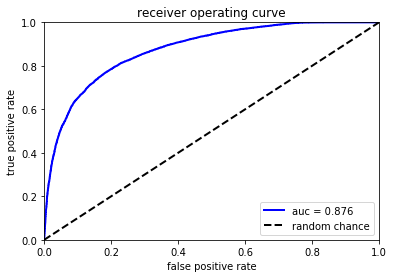

In [19]:
# Plot ROC

print(testtaus.shape)
print(testimages.shape)
print(testlabels.shape)

#predict = best_model.predict([testimages, testtaus, testmults])
predict = best_model.predict(test_variables)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,0], predict[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

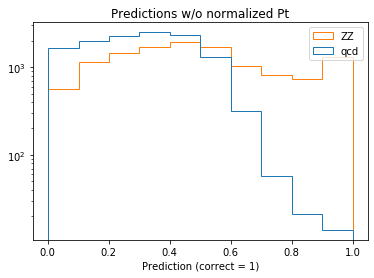

In [20]:
indqcd = np.argwhere(testlabels[:,1] == 0)
ind1  = np.where(testlabels[:,1] == 1) 
# ind2  = np.where(testlabels[:,2] == 1)
# ind3  = np.where(testlabels[:,3] == 1)
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[ind1, 1].flatten()] , histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/o normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()

$$ \textbf{LRP} $$

In [ ]:
# import innvestigate
# import innvestigate.utils as iutils

In [ ]:
# # Creating an analyzer
# lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)
# #discoverered that innvestigate fails to run on a loaded model --> trying to find fix

# # Applying the analyzer
# display = trainimages[1].reshape(1,grid,grid,1) #the reshape is this way is because the input is expected to be 4 dimensions
# analysis = lrp_analyzer.analyze(display)

# # Displaying one result
# plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar()
# plt.show()

In [ ]:
# #fix - change to predicted labels
# #plot output signal and background
# sig_analysis_true = np.zeros_like(analysis)
# bkg_analysis_true = np.zeros_like(analysis)
# sig_analysis_pred = np.zeros_like(analysis)
# bkg_analysis_pred = np.zeros_like(analysis)
# # sig_mask = trainlabels == 1
# # bkg_mask = trainlabels == 0
# # pred_sig_mask = predict >= 0.50
# # pred_bkg_mask = predict < 0.50

# toc = time.time()

# for i in range(len(trainimages)):
#     display = trainimages[i].reshape(1,grid,grid,1)
#     analysis = lrp_analyzer.analyze(display)
#     if trainlabels[i] == 1:
#         sig_analysis_true += analysis  
#     else:
#         bkg_analysis_true += analysis

# for i in range(len(trainimages)):
#     display = trainimages[i].reshape(1,grid,grid,1)
#     analysis = lrp_analyzer.analyze(display)
#     if trainlabels[i] >= 0.50:
#         sig_analysis_pred += analysis  
#     else:
#         bkg_analysis_pred += analysis

# tic = time.time()

# print('/n time = /n', tic-toc)


In [ ]:
# Displaying the signal result
# ax = plt.figure(figsize = (10,10))
# ax.add_subplot(121)
# im = plt.imshow(sig_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im,fraction=0.046, pad=0.04)
# ax.add_subplot(122)
# im_ = plt.imshow(sig_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im_,fraction=0.046, pad=0.04)

In [ ]:
# # Displaying the signal result
# ax = plt.figure(figsize = (10,10))
# plt.subplot(121)
# im_ = plt.imshow(bkg_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im_,fraction=0.046, pad=0.04)
# plt.subplot(122)
# im = plt.imshow(bkg_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im,fraction=0.046, pad=0.04)